In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox

sc.settings.verbosity = 0
sc._settings.ScanpyConfig.n_jobs = -1

Unable to contact PyPI to check for the latest sc-toolbox version. Do you have an internet connection?

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
library(edgeR)
library(MAST)

R[write to console]: Loading required package: limma

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: MatrixGenerics

R[write to console]: Loading required package: matrixStats

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, ro

In [4]:
"""
    - 差异基因表达测试是一个经典的生物信息学问题，
    - 目前从两个角度来解决这个问题，
        - 样本级视图，其中表达被聚合以创建“伪批量”，然后使用最初为批量表达样本设计的方法进行分析，
        - 例如edgeR[Robinson等人。，2010 ]或 DEseq2 [ Love等人。，2014 ]
        - 以及细胞级视图，其中使用广义混合效应模型
        - 例如 MAST）对细胞进行单独建模[ Finak2014 年] ，2015 ]或glmmTMB [ Brooks等人。，2017 ]。
----------------------------------------
    - 单细胞特异性方法特别容易将高表达基因错误地标记为差异表达。
    - 统计上不独立的生物复制。
    - 未能考虑重复（来自同一个体的细胞）的内在相关性会增加错误发现率（FDR）
    - 伪批量方法表现最好，但求和还是均值聚合效果更好还需要进一步研究。
----------------------------------------
    - 注意：流程都分为单种细胞和所有细胞，这两个结果是完全不同的。
    
"""

'\n    - 差异基因表达测试是一个经典的生物信息学问题，\n    - 目前从两个角度来解决这个问题，\n        - 样本级视图，其中表达被聚合以创建“伪批量”，然后使用最初为批量表达样本设计的方法进行分析，\n        - 例如edgeR[Robinson等人。，2010 ]或 DEseq2 [ Love等人。，2014 ]\n        - 以及细胞级视图，其中使用广义混合效应模型\n        - 例如 MAST）对细胞进行单独建模[ Finak2014 年] ，2015 ]或glmmTMB [ Brooks等人。，2017 ]。\n----------------------------------------\n    - 单细胞特异性方法特别容易将高表达基因错误地标记为差异表达。\n    - 统计上不独立的生物复制。\n    - 未能考虑重复（来自同一个体的细胞）的内在相关性会增加错误发现率（FDR）\n    - 伪批量方法表现最好，但求和还是均值聚合效果更好还需要进一步研究。\n----------------------------------------\n    - 注意：流程都分为单种细胞和所有细胞，这两个结果是完全不同的。\n    \n'

In [5]:
## 读取数据，原始数据
# TODO：原始数据有说法
adata_anno = sc.read("anndata_celltypist_anno.h5ad")
adata = adata_anno.raw.to_adata()
adata.obs = adata_anno.obs
adata.raw = adata_anno.raw.to_adata()

In [6]:
## 确认是否是原始计数
np.max(adata.X)

1437

In [7]:
adata.layers["counts"] = adata.X.copy()

In [8]:
adata

AnnData object with n_obs × n_vars = 67359 × 17066
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'discard', 'n_genes', 'doublet_score', 'predicted_doublet', 'size_factors', 'group', 'sample', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0_25', 'leiden_0_5', 'lei

In [9]:
adata.obs.patients.unique()

['s0920', 's1125', 's1231', 's0107', 's0115', 's0813', 's0816']
Categories (7, object): ['s0107', 's0115', 's0813', 's0816', 's0920', 's1125', 's1231']

In [10]:
adata.obs["group"] = adata.obs["organs"]
adata.obs["sample"] = adata.obs["patients"]

In [11]:
## 整理成本流程标准格式label,replicate,cell_type
# np.where(condition, x, y) condition为真时返回x，否则返回y
# TODO:此处格式整理为了后续很多针对字符的函数，下划线尤其重要
adata.obs["label"] = np.where(adata.obs["group"] == "LCL", "stim", "ctrl")
adata.obs["replicate"] = adata.obs["sample"].astype(str)
adata.obs["replicate"] = "patient_" + adata.obs["replicate"]
adata.obs["cell_type"] = adata.obs["celltypist_cell_label_coarse"]
adata.obs["sample"] = adata.obs["sample"] = [
    f"{rep}_{l}" for rep, l in zip(adata.obs["replicate"], adata.obs["label"])
]

In [12]:
adata.obs["sample"].unique()

array(['patient_s0920_stim', 'patient_s0920_ctrl', 'patient_s1125_ctrl',
       'patient_s1125_stim', 'patient_s1231_ctrl', 'patient_s1231_stim',
       'patient_s0107_ctrl', 'patient_s0107_stim', 'patient_s0115_stim',
       'patient_s0115_ctrl', 'patient_s0813_ctrl', 'patient_s0813_stim',
       'patient_s0816_stim'], dtype=object)

In [13]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata

AnnData object with n_obs × n_vars = 67359 × 16940
    obs: 'C0', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_antibody', 'nFeature_antibody', 'patients', 'sampletag', 'organs', 'percent.mt', 'percent.ribo', 'log10GenesPerUMI', 'batch', 'integrated_snn_res.0.5', 'seurat_clusters', 'samples', 'doublet.score', 'predicted.doublet', 'cluster', 'doublet', 'patients_organ', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'discard', 'n_genes', 'doublet_score', 'predicted_doublet', 'size_factors', 'group', 'sample', '_scvi_batch', '_scvi_labels', 'leiden', 'leiden_0_25', 'leiden_0_5', 'lei

In [14]:
## 避免转换到R出问题,去掉空格和+,-号
adata.obs["cell_type"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type"]]
adata.obs["cell_type"] = [ct.replace("+", "") for ct in adata.obs["cell_type"]]
adata.obs["cell_type"] = [g.replace("-", "_") for g in adata.obs["cell_type"]]
adata.var.index = [g.replace(" ", "_") for g in adata.var.index]
adata.var.index = [g.replace("+", "") for g in adata.var.index]

In [15]:
## 转换成真正的类别变量才能创建bulk RNAseq的伪批量
adata.obs["replicate"] = adata.obs["replicate"].astype("category")
adata.obs["label"] = adata.obs["label"].astype("category")
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")

In [16]:
print(len(adata[adata.obs["label"] == "ctrl"].obs["replicate"].cat.categories))
print(len(adata[adata.obs["label"] == "stim"].obs["replicate"].cat.categories))

6
7


In [17]:
"""
    - aggregate_and_filter是一个函数，它从原始单细胞 
    - AnnData 对象中为指定子群的每个供体创建一个伪重复的 AnnData 对象。
    - 在这里，我们还筛选出特定群体的细胞数量少于 30 个的供体。

    - 改变replicates_per_patient参数,可以为每个样本创建几个（n）个伪重复；
    - 然后细胞被分成n个大小大致相等的子集。
----------------------------------------------------------------------------
    如果单细胞实验中有多个供体，并且用户想要考虑患者的变异性，
    我们建议为每个患者创建 2 或 3 个伪重复，并将患者信息纳入设计矩阵中
"""
NUM_OF_CELL_PER_DONOR = 30


def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="sample",
    condition_key="label",
    cell_identity_key="cell_type",
    obs_to_keep=[],  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=3,  # 每个患者创建 2 或 3 个伪重复
):
    # subset adata to the given cell identity
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.A)
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [18]:
obs_to_keep = ["label", "cell_type", "replicate", "sample"]

In [19]:
adata.X = adata.layers["counts"].copy()

In [20]:
# process first cell type separately...
cell_type = adata.obs["cell_type"].cat.categories[0]
print(
    f'Processing {cell_type} (1 out of {len(adata.obs["cell_type"].cat.categories)})...'
)
adata_pb = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
for i, cell_type in enumerate(adata.obs["cell_type"].cat.categories[1:]):
    print(
        f'Processing {cell_type} ({i+2} out of {len(adata.obs["cell_type"].cat.categories)})...'
    )
    adata_cell_type = aggregate_and_filter(adata, cell_type, obs_to_keep=obs_to_keep)
    adata_pb = adata_pb.concatenate(adata_cell_type)

Processing B_cells (1 out of 9)...
Dropping the following samples:
['patient_s0920_stim', 'patient_s1231_stim']
	Processing donor 13 out of 13...

Processing DC (2 out of 9)...
Dropping the following samples:
['patient_s0107_ctrl', 'patient_s0107_stim', 'patient_s0115_stim', 'patient_s0813_ctrl', 'patient_s0920_ctrl', 'patient_s0920_stim', 'patient_s1125_ctrl', 'patient_s1125_stim', 'patient_s1231_ctrl', 'patient_s1231_stim']
	Processing donor 11 out of 11...

Processing ILC (3 out of 9)...
Dropping the following samples:
['patient_s0813_ctrl', 'patient_s0813_stim', 'patient_s0816_stim', 'patient_s0920_ctrl', 'patient_s1231_ctrl']
	Processing donor 13 out of 13...

Processing Macrophages (4 out of 9)...
Dropping the following samples:
['patient_s0816_stim']
	Processing donor 13 out of 13...

Processing Mast_cells (5 out of 9)...
Dropping the following samples:
['patient_s0813_ctrl', 'patient_s0816_stim', 'patient_s0920_stim', 'patient_s1231_ctrl', 'patient_s1231_stim']
	Processing dono

In [21]:
adata_pb.layers["counts"] = adata_pb.X.copy()

In [22]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

In [23]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["lib_size"] = np.float64(adata_pb.obs["lib_size"])  # 有int类型不能log
adata_pb.obs["log_lib_size"] = np.log(adata_pb.obs["lib_size"])

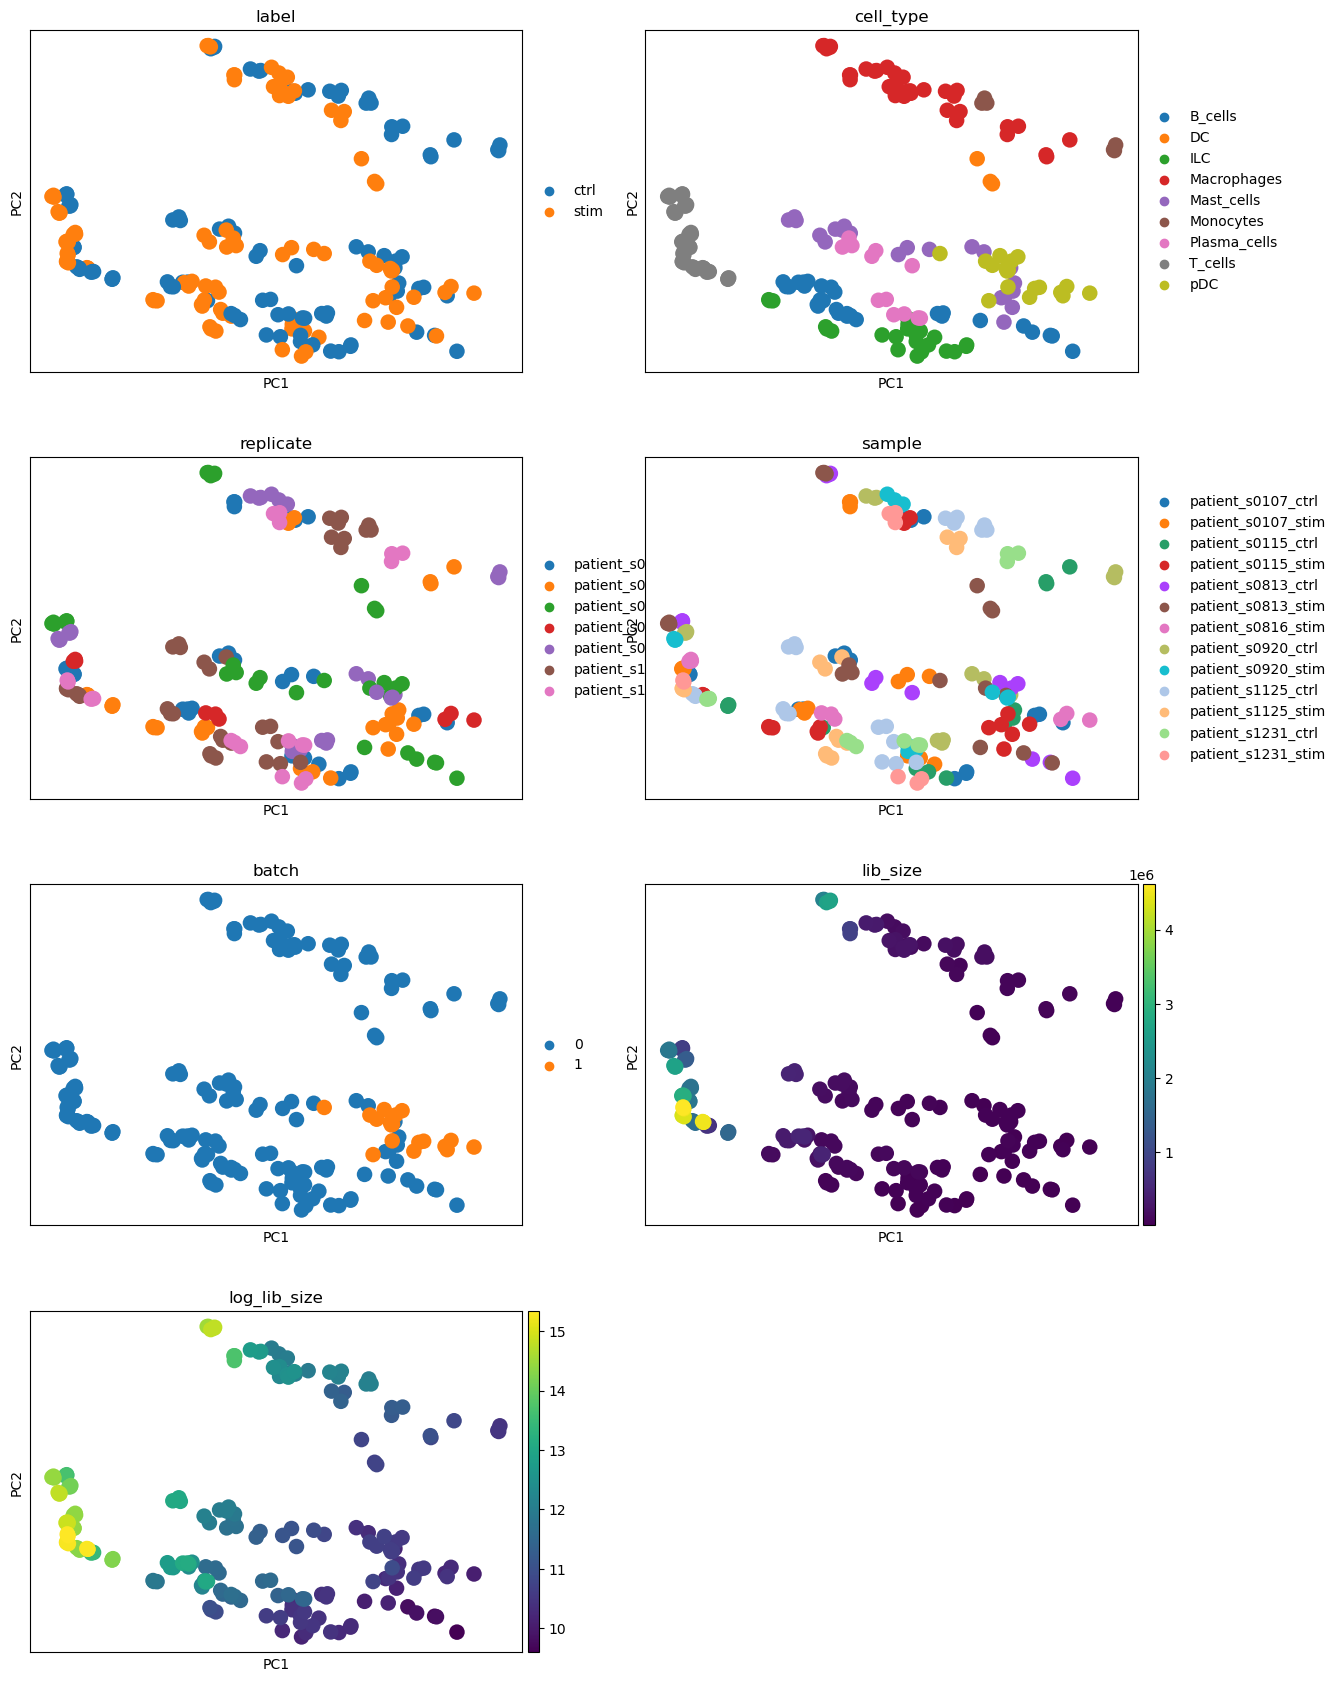

In [24]:
sc.pl.pca(adata_pb, color=adata_pb.obs, ncols=2, size=500)

In [25]:
## edgeR需要原始计数，继续放回.X
adata_pb.X = adata_pb.layers["counts"].copy()

In [26]:
adata_mono = adata_pb[adata_pb.obs["cell_type"] == "B_cells"].copy()
adata_mono

AnnData object with n_obs × n_vars = 33 × 16940
    obs: 'label', 'cell_type', 'replicate', 'sample', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'label_colors', 'cell_type_colors', 'replicate_colors', 'sample_colors', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [27]:
## 清理样本名称
adata_mono.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_mono.obs_names
]
adata_mono

AnnData object with n_obs × n_vars = 33 × 16940
    obs: 'label', 'cell_type', 'replicate', 'sample', 'batch', 'lib_size', 'log_lib_size'
    uns: 'log1p', 'pca', 'label_colors', 'cell_type_colors', 'replicate_colors', 'sample_colors', 'batch_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [28]:
mat = adata_mono.X  # numpy.ndarray
col_data = adata_mono.obs  # Pandas DataFrame
row_name = adata_mono.var.index  # 索引或列表

In [29]:
import numpy as np
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri, numpy2ri

pandas2ri.activate()
numpy2ri.activate()

In [30]:
%%R -i mat -i row_name -i col_data
sce <- SingleCellExperiment(
    assays = list(counts = mat),
    colData = col_data,
    rowData = row_name
    )
colnames(sce) = col_data$label
sce

class: SingleCellExperiment 
dim: 16940 33 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(1): X
colnames(33): ctrl ctrl ... ctrl ctrl
colData names(7): label cell_type ... lib_size log_lib_size
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [31]:
%%R
fit_model <- function(adata_, obs){
    # create an edgeR object with counts and grouping factor
    y <- DGEList(adata_, group = obs$label)
    # filter out genes with low counts
    print("Dimensions before subsetting:")
    print(dim(y))
    print("")
    keep <- filterByExpr(y)
    y <- y[keep, keep.lib.sizes=FALSE]
    print("Dimensions after subsetting:")
    print(dim(y))
    print("")
    # normalize
    y <- calcNormFactors(y)
    # create a vector that is concatentation of condition and cell type that we will later use with contrasts
    group <- paste0(obs$label, ".", obs$cell_type)
    replicate <- obs$replicate
    # create a design matrix: here we have multiple donors so also consider that in the design matrix
    
    # TODO:我这里设计矩阵不能满秩就删除replicate
    # design <- model.matrix(~ 0 + group + replicate)
    design <- model.matrix(~ 0 + group)
    # estimate dispersion
    y <- estimateDisp(y, design = design)
    # fit the model
    fit <- glmQLFit(y, design)
    return(list("fit"=fit, "design"=design, "y"=y))
}

In [32]:
%%R
fit_data = as.matrix(counts(sce))
rownames(fit_data) <- make.names(row_name, unique=TRUE)
# # %%

In [33]:
# ##TODO 插补法：一般推荐
# library(impute)
# # 进行 k 最近邻插补

# set.seed(123) # 设置随机种子以确保可重现性
# fit_data <- ifelse(fit_data == 0, NA, fit_data)
# print(sum(is.na(mat)))
# fit_data <- impute.knn(fit_data)$data
# # # %%

In [34]:
# ##TODO:推荐，重采样扩充样本
# #安装 pak::pkg_install("cran/DMwR")
# library(DMwR)
# library(dplyr)
# sample = colnames(fit_data)
# smote = fit_data %>% t() %>%
#     as.data.frame() %>%
#     dplyr::mutate(
#         group = as.factor(sample)
#         # group = ifelse(grepl("ctrl",group),"ctrl","stim")
#         )
# print(table(smote$group))
# #%%

In [35]:
# set.seed(123)
# fit_data_ <- SMOTE(group ~ ., smote,k=5, perc.over = 200, perc.under = 150)
# print(table(fit_data_$group))
# fit_data =fit_data_ %>%
#     dplyr::select(-group)
# rownames(fit_data) <- make.names(fit_data_$group, unique=TRUE)

In [36]:
%%R
library(dplyr)
obs = colData(sce) %>% as.data.frame()
outs <-fit_model(fit_data,obs)
fit <- outs$fit
y <- outs$y

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following object is masked from ‘package:Biobase’:

    combine


R[write to console]: The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


R[write to console]: The following object is masked from ‘package:GenomeInfoDb’:

    intersect


R[write to console]: The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


R[write to console]: The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


R[write to console]: The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


R[write to console]: The following object is masked from ‘package:matrixStats’:

    count


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from

[1] "Dimensions before subsetting:"
[1] 16940    33
[1] ""
[1] "Dimensions after subsetting:"
[1] 1349   33
[1] ""


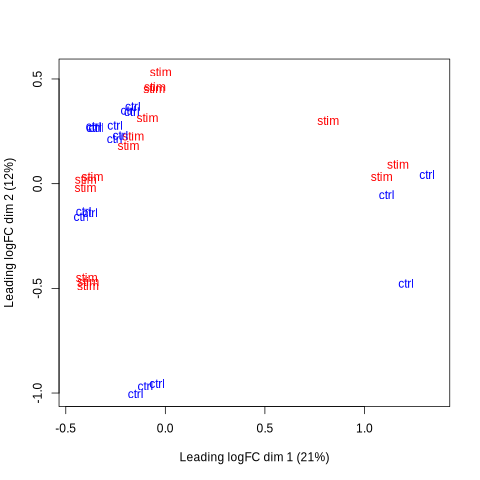

In [37]:
%%R
# """
# MDS 期望不同条件下的样本之间存在分离
# """
plotMDS(y, col=ifelse(y$samples$group == "stim", "red", "blue"))

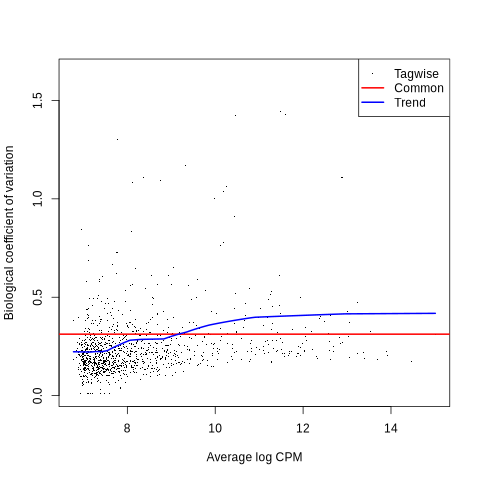

In [38]:
%%R
# 生物变异系数 (BCV) 图显示了生物群体中每个基因的平均变异性
# 低丰度基因通常表现出较大的 BCV，因为低丰度基因的读数计数测量更不确定。
# 平均表达量高的基因的定量更可靠，因此它们通常具有较低的变异性，因此 BCV 也较低。
# 出现在图右上角的一组具有高平均表达和高 BCV 的基因可以标记实验压力、污染等
plotBCV(y)

In [39]:
%%R
colnames(y$design)

[1] "groupctrl.B_cells" "groupstim.B_cells"


In [40]:
%%R -o tt
groups = colnames(y$design)
sort_groups = groups[order(as.numeric(grepl("ctrl", groups)))]
contrast = paste0(sort_groups, collapse = "-")
#TODO:手写自动实验组-对照组，没严格测试应该可以
myContrast <- makeContrasts(contrast, levels = y$design)
qlf <- glmQLFTest(fit, contrast=myContrast)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [41]:
tt.shape

(1349, 5)

In [42]:
tt[:5]

,logFC,logCPM,F,PValue,FDR
JUN,-1.178983,11.547047,44.595205,6.607202e-08,0.000089
ITGB1,1.440028,8.332003,38.237170,3.140215e-07,0.000212
HMGB2,-0.955430,7.906723,27.496959,6.125238e-06,0.002754
RHOB,-1.318341,9.573527,23.902422,1.861468e-05,0.005852
SELL,0.621655,9.077708,23.424865,2.169006e-05,0.005852


In [43]:
%%R
# 变化大于 1.5的基因会被认为是差异显著的。
tr <- glmTreat(fit, contrast=myContrast, lfc=1.5)

# 提取差异显著的基因，并将结果按照统计显著性排序。
print(head(topTags(tr)))
write.csv(tt, "diff_genes_tt.csv")
write.csv(topTags(tr), "diff_genes_tr.csv")

Coefficient:  -1*groupctrl.B_cells 1*groupstim.B_cells 
           logFC unshrunk.logFC   logCPM    PValue FDR
IGHG4  1.8622172      1.8655222 9.317799 0.1253987   1
EGR1  -1.4522869     -1.4559611 8.937559 0.2914649   1
ITGB1  1.4400276      1.4450891 8.332003 0.3229376   1
RHOB  -1.3183412     -1.3201643 9.573527 0.4774625   1
IGHA2 -1.2590794     -1.2621595 8.689702 0.5260065   1
IGHG1  0.9840903      0.9865646 8.757976 0.5268642   1


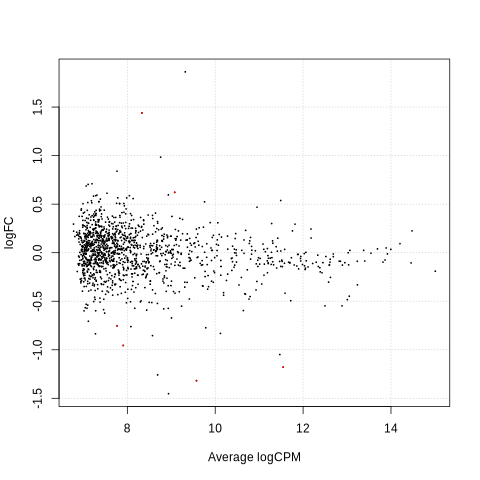

In [44]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])
# plotSmear(qlf, de.tags = rownames(tt)[which(tt$PValue<0.05)])

多个组
使用全部细胞类型


In [45]:
adata_all = adata_pb.copy()
adata_all.obs_names = [
    name.split("_")[2] + "_" + name.split("_")[3] for name in adata_all.obs_names
]
adata_all.obs_names

Index(['s0107_ctrl', 's0107_ctrl', 's0107_ctrl', 's0107_stim', 's0107_stim',
       's0107_stim', 's0115_ctrl', 's0115_ctrl', 's0115_ctrl', 's0115_stim',
       ...
       's0813_ctrl', 's0813_stim', 's0813_stim', 's0813_stim', 's0816_stim',
       's0816_stim', 's0816_stim', 's0920_stim', 's0920_stim', 's0920_stim'],
      dtype='object', length=192)

In [46]:
import rpy2.robjects as robjects

# TODO:不需要转置了,花里胡哨的传递变量总有其理由
robjects.globalenv["col_data"] = robjects.r["data.frame"](adata_all.obs)
row_name = adata_all.var.index
mat = adata_all.X

In [47]:
%%R -i mat -i row_name
sce <- SingleCellExperiment(
    assays = list(counts = mat),
    colData = col_data,
    rowData = row_name
    )
sce

class: SingleCellExperiment 
dim: 16940 192 
metadata(0):
assays(1): counts
rownames: NULL
rowData names(1): X
colnames: NULL
colData names(7): label cell_type ... lib_size log_lib_size
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [48]:
%%R
fit_data = as.matrix(counts(sce))
rownames(fit_data) <- make.names(row_name, unique=TRUE)

In [49]:
%%R
library(dplyr)
obs = colData(sce) %>% as.data.frame()
outs <-fit_model(fit_data,obs)
fit <- outs$fit
y <- outs$y

[1] "Dimensions before subsetting:"
[1] 16940   192
[1] ""
[1] "Dimensions after subsetting:"
[1] 1802  192
[1] ""


In [50]:
""" 
递归深度限制
"""
# import sys

# print(sys.getrecursionlimit())
# sys.setrecursionlimit(20000)
# print(sys.getrecursionlimit())

' \n递归深度限制\n'

In [51]:
%%R -o de_per_cell_type
de_per_cell_type <- list()
for (cell_type in unique(obs$cell_type)) {
    tryCatch({
    print(cell_type)
    # create contrast for this cell type
    myContrast <- makeContrasts(
        paste0("groupstim.", cell_type, "-groupctrl.", cell_type), 
        levels = y$design
        )
    # perform QLF test
    qlf <- glmQLFTest(fit, contrast=myContrast)
    # get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
    tt <- topTags(qlf, n = Inf)
    # save in the list with the results for all the cell types
    de_per_cell_type[[cell_type]] <- tt$table
    }, error=function(e) {
        print(e)
    })
    
}

[1] "B_cells"
[1] "DC"
<simpleError in eval(ej, envir = levelsenv): object 'groupctrl.DC' not found>
[1] "ILC"
[1] "Macrophages"
[1] "Mast_cells"
[1] "Monocytes"
<simpleError in eval(ej, envir = levelsenv): object 'groupstim.Monocytes' not found>
[1] "Plasma_cells"
[1] "T_cells"
[1] "pDC"


RecursionError: maximum recursion depth exceeded in comparison

In [ ]:
"""
保存在我们的原始对象中，就像它们是使用 scanpy函数创建的一样。
像这样存储 DE 表的优点是我们现在还可以使用标准的 scanpy 绘图函数。
----------------------------------------
但是此版本保存到字典的,会让anndata无法保存
"""

# TODO:类型错误尚未解决
# get cell types that we ran the analysis for
cell_types = de_per_cell_type.keys()
# add the table to .uns for each cell type
for cell_type in cell_types:
    df = de_per_cell_type[cell_type]
    df["gene_symbol"] = df.index
    df["cell_type"] = cell_type
    sc_toolbox.tools.de_res_to_anndata(
        adata,
        df,
        groupby="cell_type",
        score_col="logCPM",
        pval_col="PValue",
        pval_adj_col="FDR",
        lfc_col="logFC",
        key_added="edgeR_" + cell_type,
    )
    df.to_csv(f"./table/de_edgeR_{cell_type}.csv")

In [ ]:
"""
从对象中重新获取表格
"""
sc.get.rank_genes_groups_df(adata, group="Macrophages", key="edgeR_Macrophages")[:5]

In [ ]:
adata.uns["edgeR_Macrophages"]

In [ ]:
# adata.write("anndata_deg_edgeR.h5ad") #保存失败
# %store adata 保存
# 保存在这
# import IPython
# ip = IPython.get_ipython()
# db = ip.db
# print(db.root)
# %store -r adata 恢复
# %store -d adata 删除

# 单细胞特异性

MAST 框架使用两部分广义线性模型对单细胞基因表达进行建模。
MAST 的一个组件模拟细胞中每个基因的离散表达率，
而另一个组件模拟条件连续表达水平（以所表达的基因为条件）


In [ ]:
adata.X = adata.layers["counts"].copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

In [ ]:
"""
定义一个辅助函数处理单细胞到R类型转换问题
"""


def prep_anndata(adata_):
    def fix_dtypes(adata_):
        df = pd.DataFrame(adata_.X.A, index=adata_.obs_names, columns=adata_.var_names)
        df = df.join(adata_.obs)
        return sc.AnnData(df[adata_.var_names], obs=df.drop(columns=adata_.var_names))

    adata_ = fix_dtypes(adata_)
    sc.pp.filter_genes(adata_, min_cells=3)
    return adata_

In [ ]:
"""
本流程耗时，所以只选择单类

"""
## 一组细胞
## 注意此处的adata名称等在前面的流程中处理过了
adata_mono = adata[adata.obs["cell_type"] == "Epithelial_cells"].copy()
adata_mono

In [ ]:
sc.pp.filter_genes(adata_mono, min_cells=3)
adata_mono

In [ ]:
adata_mono = prep_anndata(adata_mono)
adata_mono

In [ ]:
## TODO:一种新的转换方式,先保存scanpy再读取
adata_mono.write("temp.h5ad", compression="gzip")

In [ ]:
%%R
## 读取scanpy转sce
library(SingleCellExperiment)
library(zellkonverter)

sce <- readH5AD("temp.h5ad")
counts(sce)=assay(sce,"X")
sce

In [ ]:
%%R
# 将adata_转换为SingleCellAssay对象，存储在sca中
sca <- SceToSingleCellAssay(sce, class = "SingleCellAssay")
# 打印sca的维度
print(dim(sca))
# 保留在超过所有细胞中表达的基因，表达率大于10%的基因
sca <- sca[freq(sca) > 0.1,]
# 打印过滤后sca的维度
print(dim(sca))

In [ ]:
%%R
# 计算每个细胞中表达的基因数量，并将其标准化
cdr2 <- colSums(assay(sca) > 0)
colData(sca)$ngeneson <- scale(cdr2)
# 将列数据中的"label"转换为因子，并设置参考水平为"ctrl"
label <- factor(colData(sca)$label)
label <- relevel(label, "ctrl")

In [ ]:
%%R
colData(sca)$label <- label
# 将列数据中的"cell_type"转换为因子
celltype <- factor(colData(sca)$cell_type)
colData(sca)$celltype <- celltype
# 将列数据中的"replicate"转换为因子
replicate <- factor(colData(sca)$replicate)
colData(sca)$replicate <- replicate

In [ ]:
%%R
# 创建一个"group"列，该列包含条件-细胞类型组合的信息
colData(sca)$group <- paste0(colData(sce)$label, ".", colData(sce)$cell_type)
colData(sca)$group <- factor(colData(sca)$group)

In [ ]:
%%R
# 定义并拟合模型，包括随机效应
zlmCond <- zlm(
    formula = ~ngeneson + group + (1 | replicate), # 固定效应，以及replicate作为随机效应的模型。
               sca = sca, 
               method = 'glmer', 
               ebayes = F, 
               strictConvergence = F,
               fitArgsD = list(nAGQ = 0)) # 用于加速计算
# 执行感兴趣条件的似然比检验

In [ ]:
%%R
summaryCond <- summary(zlmCond, doLRT = 'groupstim.Epithelial_cells')
# 获取包含对数折叠变化和p值的表格
summaryDt <- summaryCond$datatable
# 合并p值和logFC系数
result <- merge(summaryDt[contrast == 'groupstim.Epithelial_cells' & component == 'H', .(primerid, `Pr(>Chisq)`)],
                 summaryDt[contrast == 'groupstim.Epithelial_cells' & component == 'logFC', .(primerid, coef)],
                 by = 'primerid')
# 将logFC系数转换为以log2为底的对数，以便与edgeR进行比较
result[, coef := result[, coef] / log(2)]
# 进行多重检验校正
result[, FDR := p.adjust(`Pr(>Chisq)`, 'fdr')]
# 仅保留FDR小于0.01的结果
result = result[result$FDR < 0.01,, drop = F]
# 移除可能存在的缺失值
result <- stats::na.omit(as.data.frame(result))

In [ ]:
%%R -o res
res = result

In [ ]:
res["gene_symbol"] = res["primerid"]
res["cell_type"] = "Epithelial_cells"
sc_toolbox.tools.de_res_to_anndata(
    adata,
    res,
    groupby="cell_type",
    score_col="coef",
    pval_col="Pr(>Chisq)",
    pval_adj_col="FDR",
    lfc_col="coef",
    key_added="MAST_Epithelial_cells",
)

In [ ]:
adata.uns["MAST_Epithelial_cells"]

In [ ]:
res.to_csv("./tableMAST.csv")

In [ ]:
adata

In [ ]:
FDR = 0.05
LOG_FOLD_CHANGE = 0.5


def plot_heatmap(adata, group_key, group_name="cell_type", groupby="label"):
    cell_type = "_".join(group_key.split("_")[1:])
    res = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key)
    res.index = res["names"].values
    res = res[
        (res["pvals_adj"] < FDR) & (abs(res["logfoldchanges"]) > LOG_FOLD_CHANGE)
    ].sort_values(by=["logfoldchanges"])
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(
        adata[adata.obs[group_name] == cell_type].copy(),
        markers,
        groupby=groupby,
        swap_axes=True,
        use_raw=False,
        save=f"12-heatmap_{cell_type}.pdf",
    )

In [ ]:
adata_ = adata.copy()
adata_.var.index = [g.replace("-", ".") for g in adata_.var.index]

In [ ]:
plot_heatmap(adata_, "edgeR_Mast_cells")  # R不支持-号，会自动转换为.

In [ ]:
plot_heatmap(adata, "MAST_Epithelial_cells")

In [ ]:
FDR = 0.05
LOG_FOLD_CHANGE = 0.5


def volcano_plot(adata, group_key, group_name="cell_type", groupby="label", title=None):
    cell_type = "_".join(group_key.split("_")[1:])
    result = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots()
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.savefig(f"figures/12-{group_key}.pdf")
    plt.show()

In [ ]:
volcano_plot(adata, "edgeR_Mast_cells")

In [ ]:
volcano_plot(adata, "MAST_Epithelial_cells")

In [ ]:
for key in list(adata.uns.keys()):
    # 检查是否是字典类型
    if key.startswith("edgeR") or key.startswith("MAST"):
        print(key)
        try:
            volcano_plot(adata, key)
            plot_heatmap(adata, key)
        except Exception as e:
            print(f"An error occurred while processing {key}: {e}")
            continue

In [ ]:
adata

In [ ]:
# 保存adata对象,会保存失败
try:
    adata.write_h5ad("filename.h5ad")
except Exception as e:
    print(f"An error occurred while saving adata: {e}")